In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
import scipy
import util
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import math

In [4]:
ALL_DATA = "E:Corrected_FA/ALL_DATA/"
info_data = "idaSearch_8_01_2020.csv"

# Obtenemos los diccionarios con los nombres de los ficheros que contienen las imágenes
AD_CN, groups = util.obtain_data_files(ALL_DATA, info_data)

# Cargamos las imágenes
CN_imgs = np.array(util.load_data(ALL_DATA, AD_CN["CN"]), dtype='float32')

AD_imgs = util.load_data(ALL_DATA, AD_CN["AD"])

# Extendemos la clase con menos ejemplos
AD_imgs = np.array(util.extend_class(AD_imgs, len(CN_imgs)), dtype='float32')

# Creamos las etiquetas 1: AD, 0:CN
CN_labels = np.zeros((len(CN_imgs),1), dtype = "int32")
AD_labels = np.ones((len(AD_imgs),1), dtype = "int32")

In [5]:
test_percentaje = 0.1
val_percentaje = 0.1


test_idx = math.floor(test_percentaje * len(CN_imgs))
val_idx = math.floor(val_percentaje * len(CN_imgs)) + test_idx



test_labels = np.concatenate((CN_labels[:test_idx], AD_labels[:test_idx]))
test_size = len(test_labels)
test_imgs = np.concatenate([CN_imgs[:test_idx], AD_imgs[:test_idx]]).reshape((test_size, 91, 109, 91, 1))



val_labels = np.concatenate((CN_labels[test_idx : val_idx] , AD_labels[test_idx : val_idx]))
val_size = len(val_labels)
val_imgs = np.concatenate([CN_imgs[test_idx : val_idx], AD_imgs[test_idx : val_idx]]).reshape((val_size, 91, 109, 91, 1))



train_labels = np.concatenate((CN_labels[val_idx:] , AD_labels[val_idx:]))
train_size = len(train_labels)
train_imgs = np.concatenate([CN_imgs[val_idx:], AD_imgs[val_idx:]]).reshape((train_size, 91, 109, 91, 1))

mean = train_imgs.mean()
std = train_imgs.std()

train_imgs = (train_imgs - mean) / std
val_imgs = (val_imgs - mean) / std
test_imgs = (test_imgs - mean) / std

mean_post = train_imgs.mean()
std_post = train_imgs.std()

In [6]:
groups

{'CN ADNI2 Screening MRI-New Pt': ['ADNI_003_S_4081_MR_corrected_FA_image_Br_20120421203936832_S114205_I299596.nii',
  'ADNI_003_S_4119_MR_corrected_FA_image_Br_20120421203957860_S118964_I299597.nii',
  'ADNI_003_S_4288_MR_corrected_FA_image_Br_20120421204219669_S126262_I299603.nii',
  'ADNI_003_S_4350_MR_corrected_FA_image_Br_20120421204256784_S132511_I299605.nii',
  'ADNI_003_S_4441_MR_corrected_FA_image_Br_20120421204400594_S135910_I299608.nii',
  'ADNI_003_S_4555_MR_corrected_FA_image_Br_20120919194151538_S144329_I335690.nii',
  'ADNI_003_S_4644_MR_corrected_FA_image_Br_20120928121739312_S148164_I337177.nii',
  'ADNI_003_S_4839_MR_corrected_FA_image_Br_20120919194603302_S158754_I335724.nii',
  'ADNI_003_S_4840_MR_corrected_FA_image_Br_20120919194610469_S158770_I335725.nii',
  'ADNI_003_S_4872_MR_corrected_FA_image_Br_20120919194711136_S159411_I335733.nii',
  'ADNI_003_S_4900_MR_corrected_FA_image_Br_20120919194725964_S162275_I335735.nii',
  'ADNI_007_S_4387_MR_corrected_FA_image_Br

In [3]:
model = keras.models.load_model("Modelos/model_loss_0.3_9999_0.1_0.003_2.h5") # roll back to best model
model.compile(optimizer = keras.optimizers.Adam(3e-6), loss = tf.keras.losses.BinaryCrossentropy())

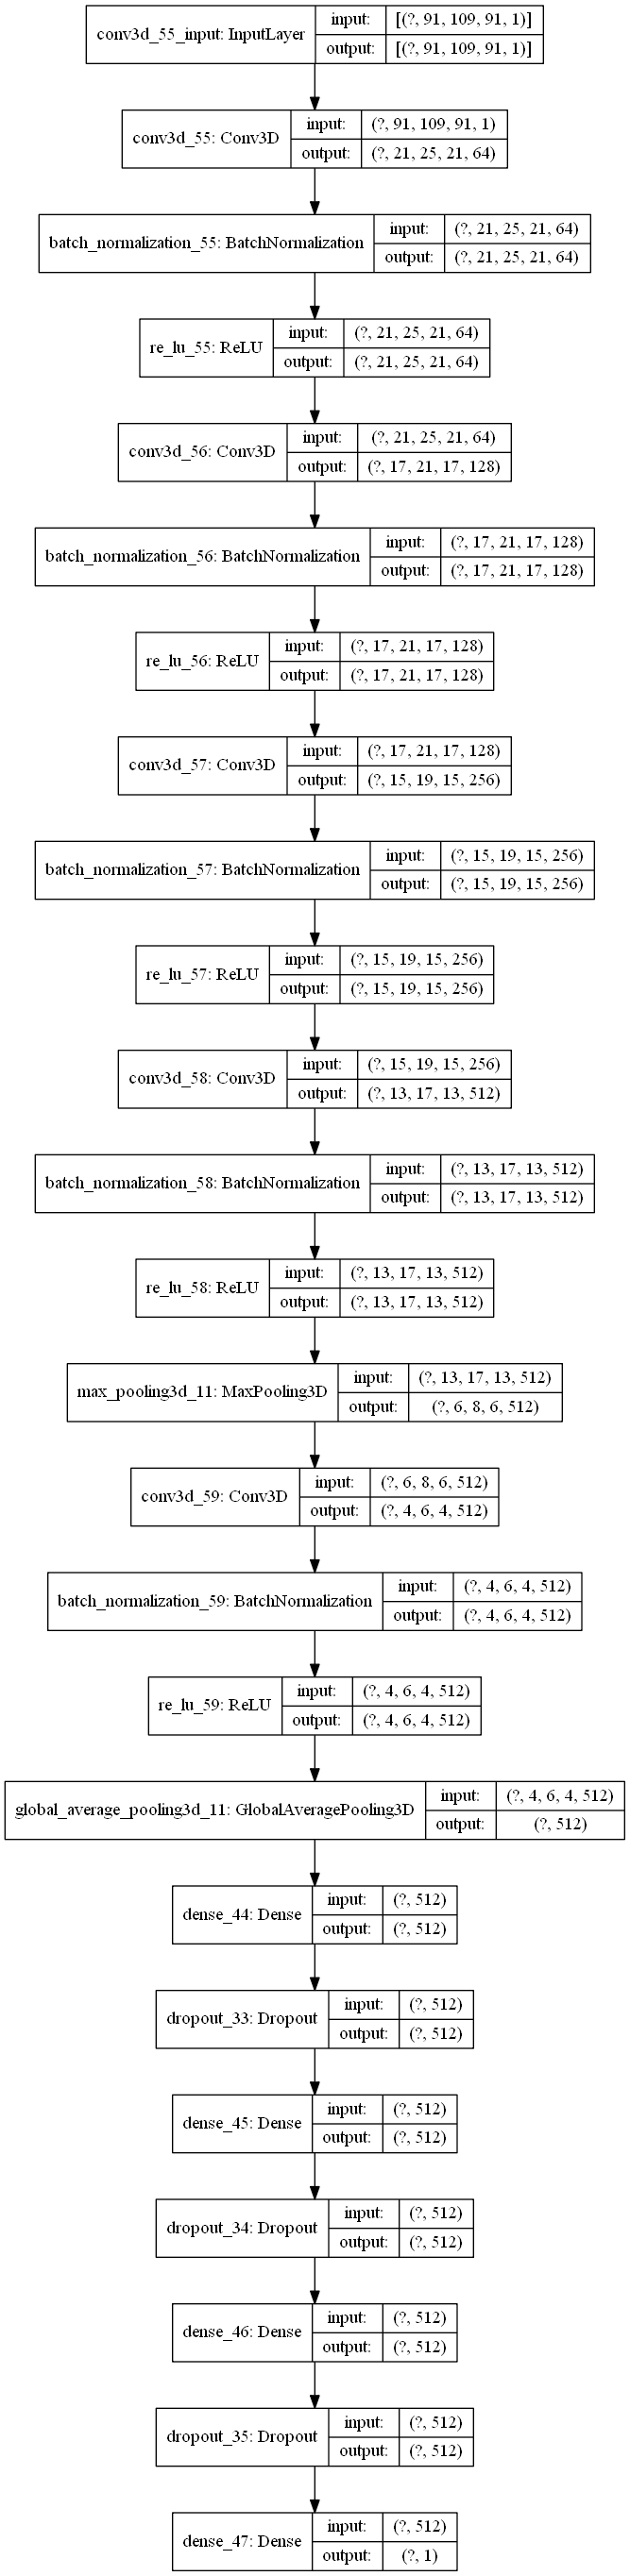

In [8]:
keras.utils.plot_model(model, to_file= "MyModel.png", show_shapes=True)

In [29]:
(91*109*91)

902629

In [45]:
def sliding_window(model, image, mean, std, muestra):
    k_size = 3
    image_tensor = tf.constant(image.reshape(1, 91, 109, 91, 1))
    p0 = model.predict(image_tensor)[0, 0]
    relevance_matrix = np.zeros((image.shape[0]-2, image.shape[1]-2, image.shape[2]-2, image.shape[3]), "float32")
    shape = relevance_matrix.shape
    total = np.count_nonzero(muestra)
    count = 0
    for i in range(image.shape[0] - (k_size - 1)):
        for j in range(image.shape[1] - (k_size - 1)):
            for k in range(image.shape[2] - (k_size - 1)):
                if muestra[i-1,j-1,k-1] != 0:
                    kernel = np.random.normal(mean, std, [3,3,3,1])
                    new_image = image.copy()
                    new_image[i:i+3, j:j+3, k:k+3] = kernel
                    p1 = model.predict(tf.constant(new_image.reshape(1, 91, 109, 91, 1)))[0, 0]
                    relevance_matrix[i, j, k] = np.log((p0/(1-p0)) / (p1/(1-p1)))    
                    count += 1
                    if count % 100 == 0:
                        print(str(count * 100 / total)+" %")
    return relevance_matrix            
                

In [75]:
def sliding_window_batch(model, images, mean, std, muestra):
    k_size = 3
    images_tensor = tf.constant(images.reshape(images.shape[0], 91, 109, 91, 1))
    p0 = model.predict(images_tensor)
    relevance_matrix = np.zeros((images.shape[0], images.shape[1]-2, images.shape[2]-2, images.shape[3]-2, images.shape[4]), "float32")
    
    total = np.count_nonzero(muestra)
    count = 0
    for i in range(images.shape[1] - (k_size - 1)):
        for j in range(images.shape[2] - (k_size - 1)):
            for k in range(images.shape[3] - (k_size - 1)):
                if muestra[i-1,j-1,k-1] != 0:
                    kernel = np.random.normal(mean, std, [images.shape[0],3,3,3,1])
                    new_image = images.copy()
                    new_image[:,i:i+3, j:j+3, k:k+3] = kernel
                    p1 = model.predict(tf.constant(new_image.reshape(images.shape[0], 91, 109, 91, 1)))
                    relevance_matrix[:,i, j, k] = np.log((p0/(1-p0)) / (p1/(1-p1)))    
                    count += 1
                    if count % 100 == 0:
                        print(str(count * 100 / total) + " %")
                   
    return relevance_matrix    

In [76]:
image = train_imgs[200]
image_tensor = tf.constant(image.reshape(1, 91, 109, 91, 1))
p0 = model.predict(image_tensor)

In [77]:
100* np.count_nonzero(CN_imgs[0])/(97*109*91)

30.536105339850728

In [78]:
relevance = sliding_window_batch(model, train_imgs[:200], mean_post, std_post, CN_imgs[0])

0.03403664385076974 %
0.06807328770153948 %


KeyboardInterrupt: 

In [ ]:
def visualizar(tens, s, axis):
    n = tens.numpy()
    if axis == 0:        
        plt.imshow(n[s, :, :, 0 ])
    elif axis == 1:        
        plt.imshow(n[:, s, :, 0 ])
    elif axis == 2:        
        plt.imshow(n[:, :, s, 0 ])